In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Functions representing dz/dt

In [7]:
def ode_torch(t,y):
    '''Example differential equation
    Args: y is initial value
          t is time'''
    t = torch.tensor(t)
    m = y - 1/2 * torch.exp(t/2) * torch.sin(5*t) + 5*torch.exp(t/2)*torch.cos(5*t)
    return m

class mini_net(nn.Module):
    
    def __init__(self, W=torch.randn(1, requires_grad=True)):
        super(mini_net, self).__init__()
        self.W = W
        
    def f(self, t, y):
        # This is dz/dt (change in hidden state with respect to time)
        return(sig(self.W * y))
    
def sig(x):
    return(torch.exp(x) / (torch.exp(x) + 1))

In [17]:
def rk_adjoint(fun, t_span, y0, h):
    '''Runge-Kutta 4th order method
        Args: - fun is derivative
              - t_span is tuple of start and end time
              - y0 is initial condition
              - h is step size (fixed in this case)'''
    w = torch.tensor([1/6, 1/3, 1/3, 1/6]) # weights
    w = w.expand(*y0.shape,4).permute(2,0,1)
    n_steps = int((t_span[1]-t_span[0])/h)
    y = y0 # set state to initial state
    t = t_span[0]
    all_y = [y0] # set state to initial state
    all_t = [t_span[0]]
    for _ in range(n_steps):
        k1 = h * fun(t     , y)
        k2 = h * fun(t+.5*h, y+.5*k1)
        k3 = h * fun(t+.5*h, y+.5*k2)
        k4 = h * fun(t+   h, y+   k3)
        t = t + h
        y = y + torch.sum(w*torch.stack([k1,k2,k3,k4],dim=0), dim=0)
        all_y.append(y)
        all_t.append(t)
    return torch.stack(all_y,dim=0).detach(), torch.tensor(all_t)

class aug_dynamics():
    '''Class representing augmented dynamics of the system. Forward dynamics are governed by .
        To update parameters, we require derivative of loss with respect to the hidden state, 
        dL/dz (i.e., the adjoint). To compute the adjoint and the derivative of the loss with 
        respect to the parameters, we use will use the ODE solver with the augmented dynamics.'''
    
    def __init__(self, f):
        
        self.f = f # function representing dynamics of hidden state (i.e. dz/dt)
        
        # Keep track of state
#         self.a = None # adjoint
#         self.z = None # 
        self.dL_dtheta = 0 # accumulate gradient of loss with respect to parameters
        
    # Def function for backward pass
    def vjp(v, fun, t, z):
        # Compute vector-jacobian product (vjp) of a(t) and df/dz
        # fun is function of z (hidden state) and t (time)
        out = fun(t, z) # forward pass
        out.backward(a) # compute vjp
        return(z.grad)

#     def forward(self, t, aug_state):
#         '''Forward pass of the dynamics. That is, evaluate the derivatives.
#             Args: t is time
#                   aug_state is tensor concatenation [a,z], i.e. adjoint state and hidden state
#                   fun is function used to evaluate ode_vjp
#             Returns: derivatives of adjoint and hidden state (respectively) with respect to time
#                         i.e. torch.concat([da/dt, dz/dt])'''
#         len_z = int(len(aug_state)/2)
#         a = aug_state[:1,:].detach()
#         z = aug_state[1:,:].detach().clone().requires_grad_(True)
        
#         # Compute derivative of adjoint with respect to time
#         dz_dt = self.f(t, z) # evaluate function 
#         dz_dt.backward(a) # get vector-jacobian product (vjp)
        
#         return torch.cat([z.grad, dz_dt.detach()], dim=0)
    
    def forward(self, t, aug_state):
        '''Forward pass of the dynamics. That is, evaluate the derivatives.
            Args: t is time
                  aug_state is tensor concatenation [a,z], i.e. adjoint state and hidden state
                  fun is function used to evaluate ode_vjp
            Returns: derivatives of adjoint and hidden state (respectively) with respect to time
                        i.e. torch.concat([da/dt, dz/dt])'''
        len_z = int(len(aug_state)/2)
        a = aug_state[:1,:].detach()                                  # adjoint state
        z = aug_state[1:2,:].detach().clone().requires_grad_(True)    # hidden state
        theta = aug_state[2:,:].detach().clone().requires_grad_(True) # parameters
        
        # Compute derivative of adjoint with respect to time
        dz_dt = self.f(t, z, theta) # evaluate function 
        dz_dt.backward(a) # get vector-jacobian product (vjp)
        
        self.dL_dtheta += theta.grad # accumulate gradient of loss with respect to parameters
        z.grad
        
        
        
        return torch.cat([z.grad, dz_dt.detach()], dim=0)

In [60]:
z = torch.randn(3,1, requires_grad=True)
W = torch.randn(4,3, requires_grad=True)

a = torch.randn(4,1)
yhat = W@z

yhat.backward(a)

In [61]:
print(z.grad)
print(W.grad)

tensor([[ 0.2984],
        [-1.5119],
        [-1.6241]])
tensor([[-0.9487, -0.9782,  0.6806],
        [-1.1018, -1.1361,  0.7904],
        [ 0.9205,  0.9491, -0.6603],
        [ 1.4693,  1.5149, -1.0540]])


### Apply adjoint method

#### First, solve for adjoint state at all times

In [18]:
mod = mini_net() # instantiate mini neural net
# fun = ode_torch # Function representing forward dynamics (i.e. dz/dt)
fun = mod.f

torch.manual_seed(0)
y = torch.randn(1) # ground truth

# Parameters for Runge-Kutta
t_span = [0.,5.]
h = .5

# Forward pass
y_forward, t_forward = rk_adjoint(fun=fun, t_span=t_span, y0=torch.tensor([[0.]]), h=h)

# Compute loss and adjoint at t=t_1
z1 = y_forward[-1,:,:].requires_grad_(True)
L = torch.mean((y-z1)**2) # compute loss
L.backward() # compute adjoint at t = t_1

# Backward pass (using adjoint)
dyn = aug_dynamics(f=fun)
y,t = rk_adjoint(fun=dyn.forward, t_span=t_span[::-1], y0=torch.cat([z1.grad, z1.detach()],dim=0), h=-h)

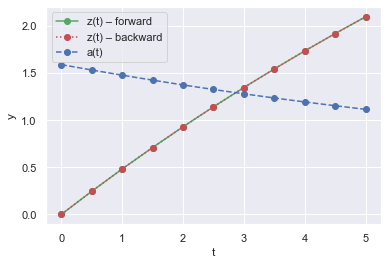

In [20]:
fig,ax=plt.subplots()
ax.plot(t_forward.numpy(),y_forward[:,0,0].numpy(), label='z(t) – forward', color='g',marker='o', linestyle='-')
ax.plot(t.numpy(),y[:,1,0].detach().numpy(), label='z(t) – backward', color='r',marker='o', linestyle=':')
ax.plot(t.numpy(),y[:,0,0].detach().numpy(), label='a(t)', marker='o', linestyle='--')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.legend()
plt.show()

#### Next solve for derivative of loss with respect to parameters